# W261 Final Project: Click Through Rate Prediction
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

__`Rutika Banakar, Stanley Opara, Subha Vadakkumkkor`__


# Section1: Introduction

Criteo Labs is an advertising platform that works with online retailers to personalized online display advertising to consumers who have visited the advertiser's website. Online advertising is a major business for internet companies and one of the core problem in that field is to be able to match the right advertisement to the right user at the right time. For ads on most websites and search engines, advertisers only pay for measurable user responses such are clicks on the ads and other actions that users take on the website such as registering, purchasing etc. Thus an optimal approach (as a search engine) is to choose an ad based on expected value, which is price of a click times the likelihood that the ad will be clicked.  Inappropriate advertising will result in worse user experience and wasted resources.  In order for websites to maximize expected value, they need to accurately predict the likelihood that a given ad will be clicked, also known as click-through rate (CTR).  

Scalability and machine learning are thus at the core of the company.  

# Notebook Set-Up


In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw5_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [5]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

from pyspark.sql import functions as F

__`REMINDER`__: If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Section2: Problem definition


In this exercise, we will explore Criteo's click through data to understand and predict response rates. The data is one week's worth of browsing data shared as part of a Kaggle competition and the objective is to predict the probability that he will click on a given data given a user and the page that he is visitng. 

An ideal solution will not only have a high accuracy, but will also be fast to train, score, scalable and interpretable. While higher accuracy is better, a minimum of at least 85% is required to generate confidence in the model and to make the effort worthwhile (or just A/B testing might be a better alternative).  There are several other considerations like how many sub-models are expected eventually (based on product and demographics), how often scoring is expected to be done (weekly or daily or more often, etc), how often re-training needs to be done (adaptive vs static) that we currently do not have a lot of insight into but are critical in a real world scenario. We will also assume here that the cost of false positives and mis-classified predictions is limited to unrecognized revenue.

Our problem at hand is a classification problem where we try to predict a binary response variable based on the click data. While there are several classification algorithms, we plan to use Logistic Regression as a starting point. Fusion methods that combine the simplicity of regressions with the complexity of something such as neural nets or ensembles have traditionally shown to work better than a single approach in the area of CTR, and ideally we would like to try a fusion approach, but given the time constraints we will use Logistic Regression.     

## Download the data

__File descriptions:__

* __train.txt__ - The training set consists of a portion of Criteo's traffic over a period of 7 days. Each row corresponds to a display ad served by Criteo. Positive (clicked) and negatives (non-clicked) examples have both been subsampled at different rates in order to reduce the dataset size. The examples are chronologically ordered.
* __test.txt__ - The test set is computed in the same way as the training set but for events on the day following the training period.



In [6]:
!mkdir data

mkdir: cannot create directory `data': File exists


In [7]:
#Read data file, cache and count the rows
bigtrainRDD = sc.textFile('data/train.txt').map(lambda k: k.split('\t')).cache()
bigtrainRDD.count()


45840617

In [8]:
# Create a temp sample - this is not a random sample but just the top 2000 rows to use for demo purposes
!head -n 2000 data/train.txt > data/train_top2000.txt
!head -n 2000 data/test.txt > data/test_top2000.txt

toptrainRDD = sc.textFile('data/train_top2000.txt').map(lambda k: k.split('\t')).cache()

print(toptrainRDD.count())

2000


In [32]:
!head -n 5 data/train_top2000.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16
0	2	0	44	1	102	8	2	2	4	1	1		4	68fd1e64	f0cf0024	6f67f7e5	41274cd7	25c83c98	fe6b92e5	922afcc0	0b153874	a73ee510	2b53e5fb	4f1b46f3	623049e6	d7020589	b28479f6	e6c5b5cd	c92f3b61	07c540c4	b04e4670	21ddcdc9	5840adea	60f6221e		3a171ecb	43f13e8b	e8b83407	731c3655
0	2	0	1	14	767	89	4	2	245	1	3	3	45	287e684f	0a519c5c	02cf9876	c18be181	25c83c98	7e0ccccf	c78204a1	0b153874	a73ee510	3b08e48b	5f5e6091	8fe001f4	aa655a2f	07d13a8f	6dc710ed	36103458	8efede7f	3412118d			e587c466	ad3062eb	3a171ecb	3b183c5c		
0		893			4392		0	0	0		0			68fd1e64	2c16a946	a9a87e68	2e17d6f6	25c83c98	fe6b92e5	2e8a689b	0b153874	a73ee510	efea433b	e51ddf94	a30567ca	3516f6e6	07d13a8f	18231224	52b8680f	1e88c74f	74ef3502			6b3a5ca6		3a171ecb	9117a34a		
0	3	-1		0	2	0	3	0	0	1	1		0	8

In [10]:
#Create a random sample
trainRDDsample=bigtrainRDD.takeSample(False,2000,seed=201812)
# len(trainRDDsample)

# Section3: Logistic Regression    

While linear regression is used to predict a continuous numeric variable, logistic regression is used to classify a set of data points into one or more classes using a similar regression approach. It uses a sigmoid function to get to the probabilities. Conceptually:

If p is the probability of one class, then p/(1 − p) is the corresponding odds or the logit of the probability is the logarithm of the odds, i.e.

${logit} (p)$ =$\log(\frac{p}{1-p})$

For linear regression, the hypothesis is:

$h_θ(x)$ =$\theta^{T}(x)$

For classification hypothesis is:

$h_θ(x)$ =$g(\theta^{T}(x))$

where g is the sigmoid function:

$g(z)$ = $\frac{1}{(1 + e^{-z})}$


Cost function for Logistic is not MSE, unlike linear regression because we use a sigmoid non-linear transformation. Squaring this can result in multiple local minima and a non-convex function thus making it difficullt for gradient descent to converge to a global minima.So we use a cost function called Log Loss or Cross Entropy, which is defined for each of the two classes.  

    class1_cost = -labels*log(predictions)

    class2_cost = (1-labels)*log(1-predictions)

Final cost is class1_cost - class2_cost, which is then summed and averaged across all observations. 


# Section4: EDA



__Data fields:__

* __Label__ - Target variable that indicates if an ad was clicked (1) or not (0).
* __I1-I13__ - A total of 13 columns of integer features (mostly count features).
* __C1-C26__ - A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes. The semantic of the features is undisclosed.

Since the names or descriptions of the fields are not available, below is a list of what we believe the fields used for a modeling exercise such as this should be:

1. An user id so we can track short term and long term patterns of a given customer/visitor. We exxpect brand loyalty to be a key factor for several consumer facing goods   
2. Date of the visit: seasonality is important, and so is day of the week, time of visit, etc  
3. Device based information : we can derive user-device based fields to see if certain uses are more responsive to say mobile vs web ads  
4. Placement of the ads/banner: size, location, orientation, color based features, etc  
5. Product based features  
6. Customer demographics  including product purchase history if available  
7. Any other relevant details: other marketing events, holidays, other offers the user may have received simulataneously or in the recent past
8. Geographical fields  

We do not have specific information of whether the available data is complete 1 week or sampled/sub-sampled and whether the non-responded ads are sampled at a different rate than responded ads. These are critical pieces of information for a real world problem.  




In the sections below we will explore the distributions of the fields. We use multiple methods for the sake of demonstration that there are various ways to approach a problem and the final solution maybe a fusion of approaches. While in a real world problem we will not use all the approaches below, the idea here is to demonstrate uses and possibilities and application of course concepts.

#### Response rates
The first thing we want to check is the count of the ads that were clicked (label=1) and count of ads that were not clicked (label=0) and also get what percent of ads in the dataset were actually clicked. In this case we can do that by just taking the mean of the label column. We see the overall CTR is 25.6%.

In [45]:
def EDA1(rdd):
    total, total_clicked = None, None
    
#     result = rdd.map(lambda line: line.split('\t')[0]).cache()

    total = rdd.count()
    total_clicked = rdd.map(lambda x: x[0]).reduce(lambda a, b: int(a) + int(b))
    
    return total, total_clicked

In [49]:
# EDA1 on the entire data
start = time.time()
total, total_clicked = EDA1(bigtrainRDD)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 1365.7665083408356 seconds


In [50]:
total_unclicked = total - total_clicked
mean = total_clicked / float(total)

In [51]:
print("Training dataset size: ", total)
print("Total examples with positive Label: ", total_clicked)
print("Total negative examples: ", total_unclicked)
print("Percent of ads in the data that were actually clicked: ", mean)

Training dataset size:  45840617
Total examples with positive Label:  11745438
Total negative examples:  34095179
Percent of ads in the data that were actually clicked:  0.2562233837297609


#### Field distributions

Below we get distributions of numeric and categorical fields on the random sampled data. We use pandas here for better visualization and ease of use. We also expect the distributions from a random sample to correspond to the unsampled data. Although the sample size here is small, ideally we could extract a larger sample of a few hundred thousand rows for better stats.

In [29]:
## Define column names and read the sampled data into a dataframe
basedata=trainRDDsample

FIELDS=["Label","I1","I2","I3","I4","I5","I6","I7","I8","I9","I10","I11","I12","I13","C1","C2","C3","C4","C5","C6","C7","C8"
       ,"C9","C10","C11","C12","C13","C14","C15","C16","C17","C18","C19","C20","C21","C22","C23","C24","C25","C26"]

# sample = np.array(basedata.map(lambda x: x).takeSample(False, 2000))
pDF = pd.DataFrame(np.array(trainRDDsample), columns = FIELDS)

Since the numeric fields were read in as objects, we convert them to numeric. THis could also save some memory usage as python uses lesser bytes for floats than objects. From the histograms, we can see that some of the numeric variables are continuous while some are discrete. For the discrete variables, we do not have an understanding of whether these are ordinal or if they are equivalent to classes without a ranking. Some of the variables such as l5 have outliers that could be potentially capped. In order to cap outliers, while this takes additional iterations, the ideal way is to check if these large data points are actually influential to our final model (using metrics like Cook's distance for example) and treat only outliers that are influential. THs may be out of scope for this report. Variables such as l4 seem to capture some variation.  

We have not yet looked at missing values here and this is just an analysis of fields distributions when populated.  

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f33912c6a20>,
      dtype=object)

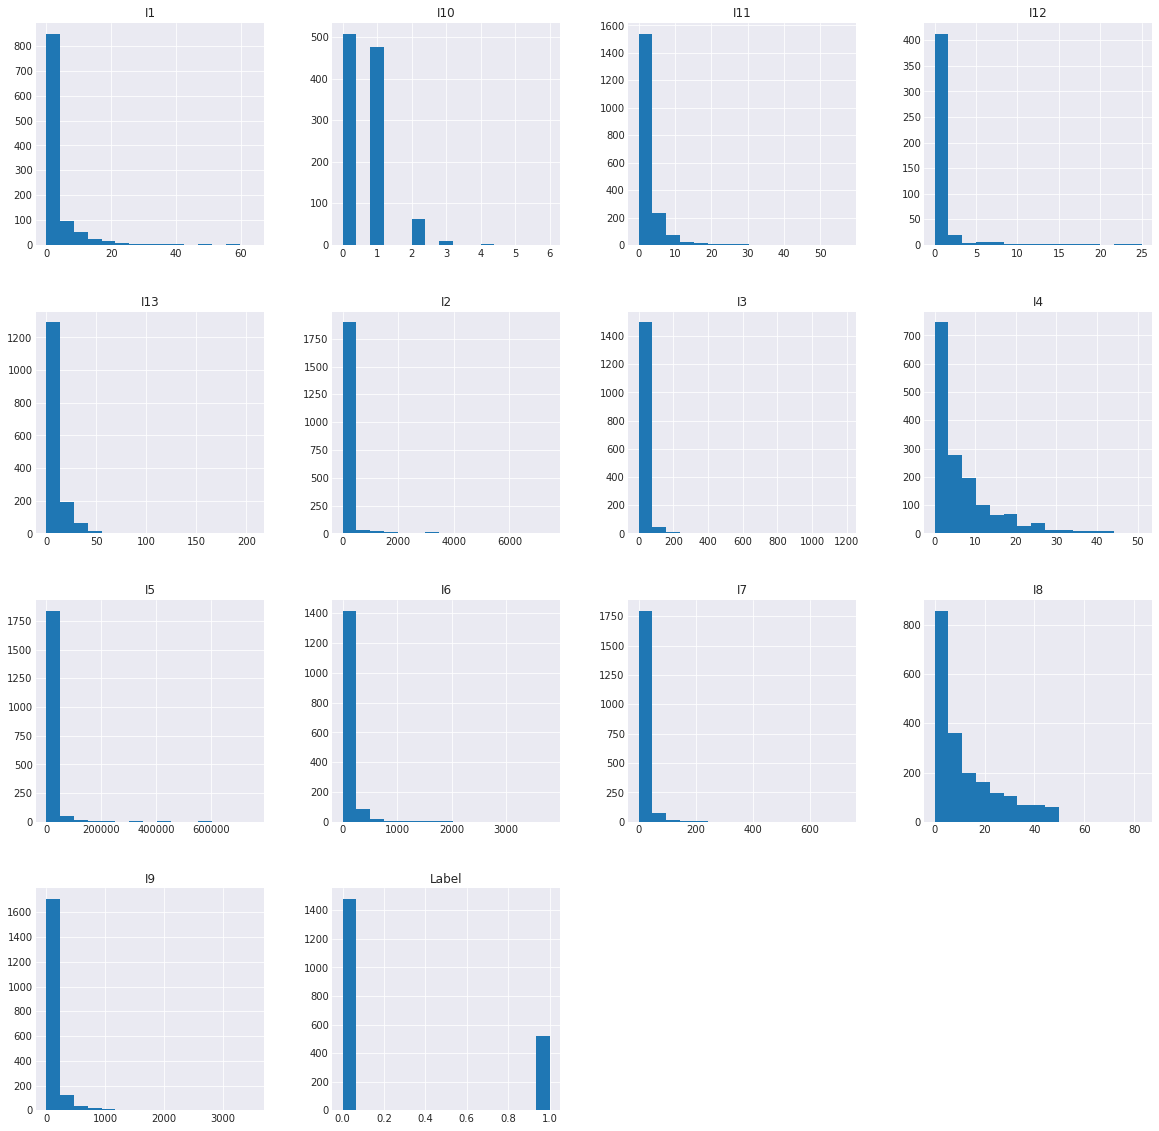

In [23]:
#Convert to numeric and plot histograms
pDF[FIELDS[0:14]].convert_objects(convert_numeric=True).hist(figsize=(20,20), bins=15)

In the next section here, we plot bar charts for categorical variables. However, as we do not have a business understanding, some of these could be equivalent of user ids or IPs or other indicators that are too granular to be able to help predict. As a work around, we will look at the number of unique values of each variable and plot all if number of unique values <30 or plot only the top 30 values. Variables such as C12, C7 have a high number of unique values and thus may not be particularly predictive. Variables such as C8 could stand for a week number, while C6 may be day of the week. These are of course guesses based on the number of unique counts, and the lack of understanding is one of the challenges while analyzing EDA results. 

Number of unique values for  C1  :  83
Number of unique values for  C2  :  262
Number of unique values for  C3  :  1373
Number of unique values for  C4  :  1126
Number of unique values for  C5  :  26
Number of unique values for  C6  :  7
Number of unique values for  C7  :  1221
Number of unique values for  C8  :  52
Number of unique values for  C9  :  3
Number of unique values for  C10  :  1029
Number of unique values for  C11  :  953
Number of unique values for  C12  :  1326
Number of unique values for  C13  :  849
Number of unique values for  C14  :  19
Number of unique values for  C15  :  906
Number of unique values for  C16  :  1235
Number of unique values for  C17  :  9
Number of unique values for  C18  :  601
Number of unique values for  C19  :  209
Number of unique values for  C20  :  4
Number of unique values for  C21  :  1281
Number of unique values for  C22  :  7
Number of unique values for  C23  :  11
Number of unique values for  C24  :  788
Number of unique values for  C25 

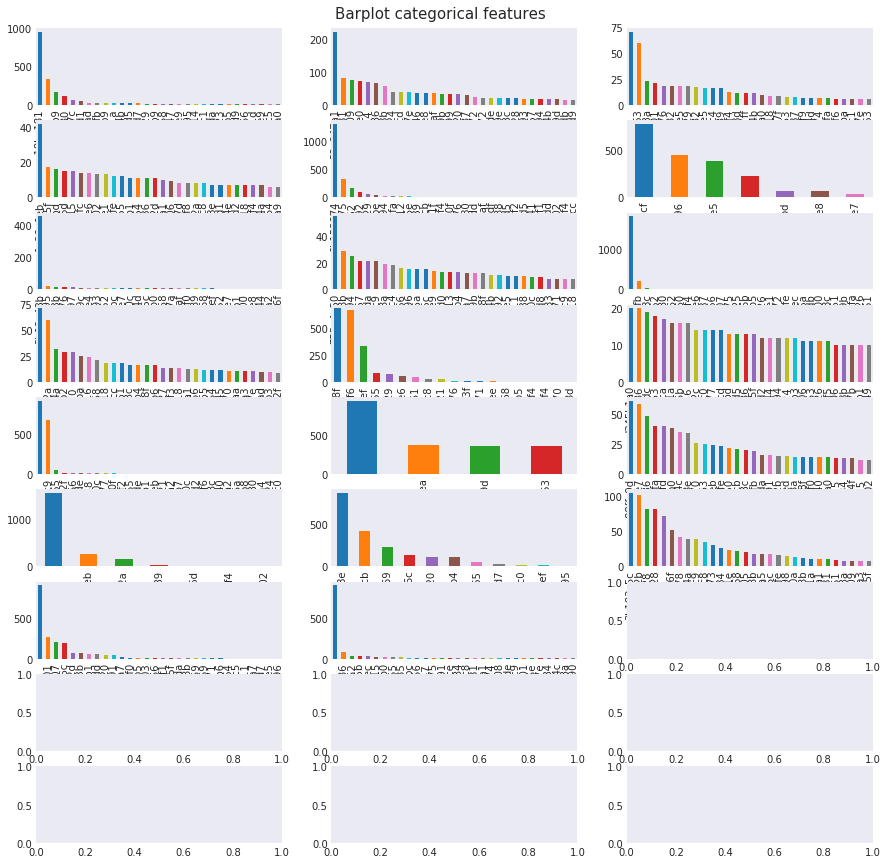

In [24]:
#Bar plot of categorical variables - plot top 30 values
fig, ax_grid = plt.subplots(9, 3, figsize=(15,15))
for idx, feature in enumerate(FIELDS[14:]):
    x = pDF[feature].value_counts()
    print("Number of unique values for ",feature," : ",x.shape[0])
    #sns.barplot(x, ax=ax_grid[idx//8][idx%3], orient='h', linewidth=.5)
    if (x.shape[0]<=30):
        x.plot(kind='bar',ax=ax_grid[idx//4][idx%3])
        ax_grid[idx//4][idx%3]
    else:
        x.head(30).plot(kind='bar',ax=ax_grid[idx//4][idx%3])
        ax_grid[idx//4][idx%3]
fig.suptitle("Barplot categorical features", fontsize=15, y=0.9)
plt.show()

Next we look at box plots by each outcome label to see which fields capture the variation better than othes. From the skewed distributions as well as lack of striking difference in variable distributions by label, none of the variables stand out as potentially highly predictive.

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


Mean of field  I1  :  3.400943396226415
Mean of field  I2  :  110.0125
Mean of field  I3  :  20.10613810741688
Mean of field  I4  :  7.060509554140127
Mean of field  I5  :  17768.980030721967
Mean of field  I6  :  100.02825947334618
Mean of field  I7  :  13.496861924686192
Mean of field  I8  :  12.396896896896896
Mean of field  I9  :  101.51464435146444
Mean of field  I10  :  0.6122641509433963
Mean of field  I11  :  2.5523012552301254
Mean of field  I12  :  0.8205689277899344
Mean of field  I13  :  7.793630573248407


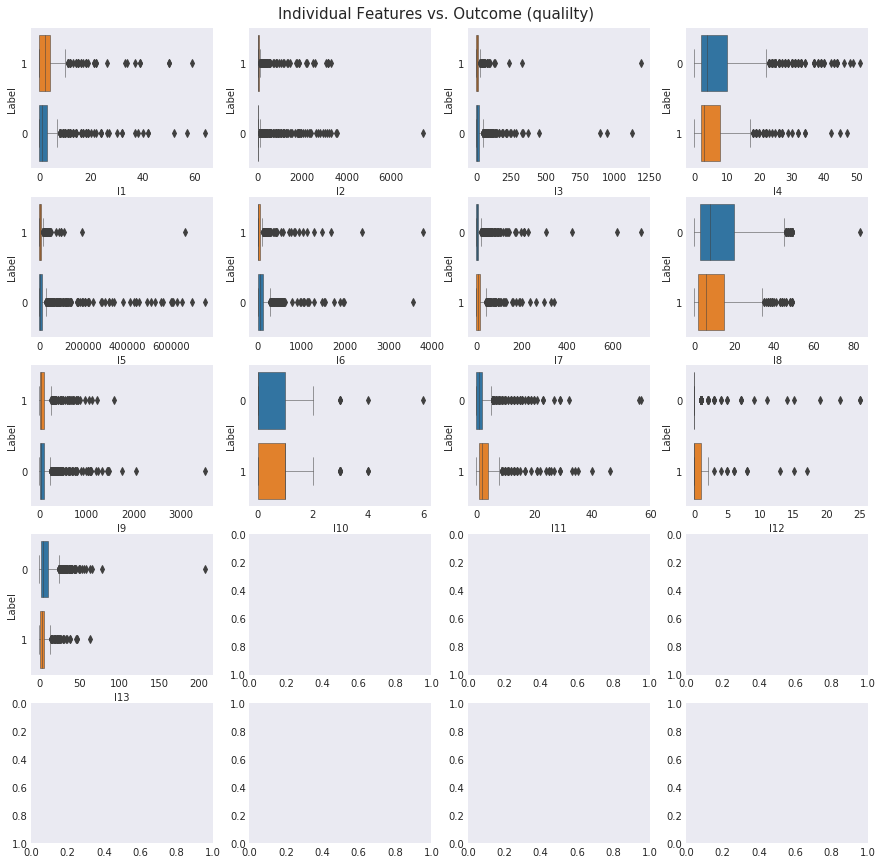

In [26]:
fig, ax_grid = plt.subplots(5, 4, figsize=(15,15))
y =  pDF['Label']
for idx, feature in enumerate(FIELDS[1:14]):
    x = pDF[feature].convert_objects(convert_numeric=True)
    print("Mean of field ",feature," : ",x.mean())
    sns.boxplot(x, y, ax=ax_grid[idx//4][idx%4], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%4].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
plt.show()

In [27]:
pDF.describe()

,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
count,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
unique,2,41,332,132,49,1474,339,122,52,378,...,9,601,209,4,1281,7,11,788,30,584
top,0,,0,,,,,0,0,,...,e5ba7672,e88ffc9d,,,,,32c7478e,3b183c5c,,
freq,1479,940,359,436,430,47,443,439,219,88,...,944,61,906,906,71,1546,874,104,906,906


From the correlation plots, there are no strong negative correlations while there are some strong positive correlations like l4 and l13, l7 and l11, etc. It is surprising that there are no strong negative correlations. Due to strong positive correlations, there will be overlap between the variance explained by the variables. 

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


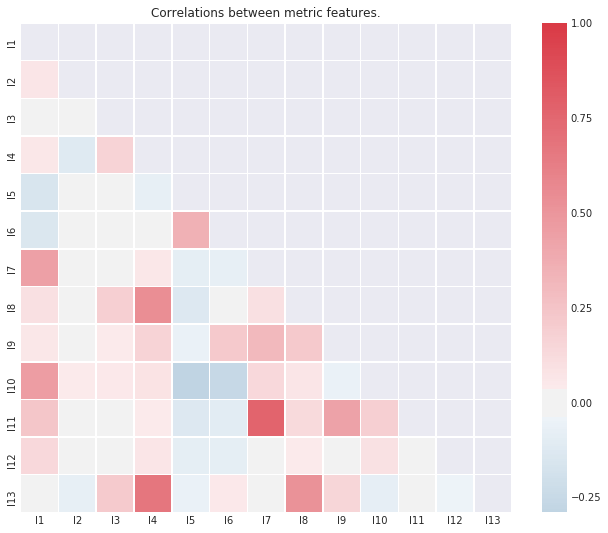

In [28]:
corr = pDF[FIELDS[1:14]].convert_objects(convert_numeric=True).corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between metric features.")
plt.show()

#### Exploration: DataFrames and Parquet approach
This section is an add on to try and apply dataframes and parquet files. Since most EDA was accomplished with panda dataframe on sampled data, here will look to get some stats on the unsampled data so we can get a better idea of the datasets. Since parquet files are columnar and more efficient, we should be able to get better performance using spark SQL-parquet combination.

In [ ]:
# dataDF = sqlContext.read.option("delimiter", "\t").csv("/media/notebooks/Assignments/FinalProject/data/train_top2000.txt")
dataDF = sqlContext.read.option("delimiter", "\t").csv("/media/notebooks/Assignments/FinalProject/data/train.txt")

The data is read through an inferred schema as the input file did not have any headers, metadata or pre-defined schema. The names of the columns are also autoamtically set by Spark. 

In [ ]:
dataDF.printSchema()

In [ ]:
%%time
#Number of missing values in each column
from pyspark.sql.functions import lit,col

rows = dataDF.count()
summary = dataDF.describe().filter(col("summary") == "count")
summary.select(*((lit(rows)-col(c)).alias(c) for c in dataDF.columns)).show()

In [53]:
print((dataDF.count(), len(dataDF.columns)))

(45840617, 40)


Let us now also read the file into Parquet format and get average of numeric columns for each label. Something we wanted to try but did not have enough time was to partiion the parquet file by label and implement some of the map reduce sorting ideas to see if we can get a better performance using partitioned data. 

In [ ]:
#Using parquet files
# data.write.format("parquet").save("/media/notebooks/Assignments/FinalProject/data/data.parquet_small")
# data_parquet = spark.read.parquet("/media/notebooks/Assignments/FinalProject/data/data.parquet_small")

data.write.format("parquet").save("/media/notebooks/Assignments/FinalProject/data/data.parquet_alldata")
data_parquet = spark.read.parquet("/media/notebooks/Assignments/FinalProject/data/data.parquet_alldata")

In [ ]:
%%time
data_parquet.count()

In [ ]:
# data_parquet.write.partitionBy("label").parquet("hdfs://<namenode>:<port>/path/to/file")

In [ ]:
#Mean by label
%%time
data_parquet.groupby(data_parquet._c0).agg(F.avg(data_parquet._c0),F.avg(data_parquet._c1),F.avg(data_parquet._c2),F.avg(data_parquet._c3),F.avg(data_parquet._c4),F.avg(data_parquet._c5),F.avg(data_parquet._c6),F.avg(data_parquet._c7),F.avg(data_parquet._c8),F.avg(data_parquet._c9),F.avg(data_parquet._c10),F.avg(data_parquet._c11),F.avg(data_parquet._c12),).collect()
# data_parquet.select(Seq("_c0", "_c1").map(mean(_)): _*).show()//
# data_parquet.select(Seq("_c0", "_c1").map(mean(_)): _*).show()
#Can expand this to more columns

In [ ]:
# https://developer.ibm.com/hadoop/2016/01/14/5-reasons-to-choose-parquet-for-spark-sql/
# https://www.slideshare.net/BarakGitsis/scaling-out-logistic-regression-with-spark

## Toy example

Now that we did some EDA and have an understanding of the data, in this section below we try to hand code some of the modeling functionalities. We will scale the numeric features using max and min, and also create dummy variables for categorical values. We also impute missing values with 0 while scaling - this is because there is no context to what the variables are and it is not cleear what the right imputation should be. 

In [52]:

FIELDS1=['_c0','_c1','_c2','_c3','_c4','_c5','_c6','_c7','_c8','_c9','_c10','_c11','_c12','_c13','_c14','_c15','_c16','_c17','_c18','_c19','_c20','_c21','_c22','_c23','_c24','_c25','_c26','_c27','_c28','_c29','_c30','_c31','_c32','_c33','_c34','_c35','_c36','_c37','_c38','_c39']
TARGET = FIELDS1[0]
METRIC_FEATURES = FIELDS1[1:14]
CAT_FEATURES = FIELDS1[14:]

### Scaling Metric Features

Below we scale the numeric features. 

In [ ]:
from pyspark.sql.functions import min, max, col, lit,when,udf
from pyspark.sql.types import DoubleType

tmpDF = dataDF
for feature in METRIC_FEATURES:
     
    tmpDF = tmpDF.na.fill({feature: '0'})
    tmpDF = tmpDF.withColumn(feature,when(col(feature) == '', lit(0)).otherwise(col(feature).cast(DoubleType())))
    featureStats = tmpDF.agg(min(col(feature)), max(col(feature))).collect()
    max_value = featureStats[0][1]
    min_value = featureStats[0][0]
    udf_myFunction = udf(lambda z: (z - min_value) / (max_value - min_value), DoubleType())
    tmpDF = tmpDF.withColumn(feature, udf_myFunction(col(feature))) 
df = tmpDF

### Dummyfying Categorical Features

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator

tmpDF = df
tmpDF = tmpDF.na.replace("", "NA", FIELDS[14:])
##Indexing categorical strings
for field in FIELDS[14:]:
    indexer = StringIndexer(inputCol=field, outputCol= field + "Index")
    indexer.setHandleInvalid("skip")
    tmpDF = indexer.fit(tmpDF).transform(tmpDF)

##Apply One HOT Encoding
tmpDF = tmpDF.drop(*FIELDS[14:])
encoder = OneHotEncoderEstimator(inputCols=[field + "Index" for field in FIELDS[14:]],
                                 outputCols=[field + "Vec" for field in FIELDS[14:]])

model = encoder.fit(tmpDF)
df = model.transform(tmpDF)

In [ ]:
df.printSchema()

### Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType

df = df.withColumn("label", col("label").cast(IntegerType())) 
assembler = VectorAssembler(
    inputCols = df.columns[1:],
    outputCol="features")

output = assembler.transform(df)
df = output.select("features", "label")


lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(df)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

## Numpy implementation

In [66]:
pd_subset=pDF[['Label','I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13','C5','C9','C8','C14','C17','C20','C22','C23','C25']]
pDF2 = pd.get_dummies(pd_subset,columns=['C5','C9','C8','C14','C17','C20','C22','C23','C25'])
# pDF2 = pDF2.drop(['C5','C9','C8','C14','C17','C20','C22','C23','C25'])
pDF2=pDF2.astype(float)
# # pDF2=pDF2[FIELDS[0:14]].astype(float)

pDF2.dtypes


ValueError: could not convert string to float: 

In [53]:

# X = pDF.loc[:, pDF.columns != 'label']
# y = pDF.loc[:, pDF.columns == 'label']


def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum( target*scores - np.log(1 + np.exp(scores)) )
    return ll

def logistic_regression(features, target, num_steps, learning_rate, add_intercept = False):
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))
        
    weights = np.zeros(features.shape[1])
    
    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        # Update weights with gradient
        output_error_signal = target - predictions
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient
        
        # Print log-likelihood every so often
        if step % 10000 == 0:
            print(log_likelihood(features, target, weights))
        
    return weights

# weights = logistic_regression(X, Y,
#                      num_steps = 300000, learning_rate = 5e-5, add_intercept=True)


# Section4: Implementation 

# Section5: Course concepts 

● scalability / time complexity / I/O vs Memory  
● functional programming / higher order functions / map reduce paradigm  
● bias variance tradeoff / model complexity / regularization  
● associative/commutative operations  
● race conditions / barrier synchronization / statelessness  
● the shuffle / combiners / local aggregation  
● order inversion pattern / composite keys  
● total order sort / custom partitioning  
● broadcasting / caching / DAGs / lazy evaluation  
● GD - convex optimization / Batch vs stochastic  
● sparse representation (pairs vs stripes)  
● preserving the graph structure / additional payloads   
● One Hot Encoding / vector embeddings / feature selection  

n more specific terms, we can think of regularization as adding (or increasing the) bias if our model suffers from (high) variance (i.e., it overfits the training data). On the other hand, too much bias will result in underfitting (a characteristic indicator of high bias is that the model shows a "bad" performance for both the training and test dataset). We know that our goal in an unregularized model is to minimize the cost function, i.e., we want to find the feature weights that correspond to the global cost minimum (remember that the logistic cost function is convex).

### COnsideations: 
Memory usage of certain data types
The first thing we want to check is the count of the ads that were clicked (label=1) and count of ads that were not clicked (label=0) and also get what percent of ads in the dataset were actually clicked. In this case we can do that by just taking the mean of the label column.